In [1]:
import time
import h5py
import os, sys
import numpy as np
from astropy.io import fits
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook


from matplotlib.colors import ListedColormap
pmap = ListedColormap(np.load('/Users/belugawhale/parula_data.npy'))
colors = np.load('/Users/belugawhale/parula_colors.npy')

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

import juliet, corner
from niriss.nestor_transit_fitting import fit_lightcurves
from niriss.juliet_utils import create_data_dictionary, create_priors_dictionary, corner_plot

In [3]:
data = h5py.File('ADF_extracted_wasp39_v3.h5')
wasp = 39

In [5]:
times = np.array(data['time'])
if wasp==96:
    badinds = np.sort(np.array([52, 103, 152, 159, 144, 180, 183]))
    allinds = np.arange(0,len(times),1,dtype=int)
    goodinds = np.delete(allinds, badinds)
else:
    goodinds=np.arange(0,len(times),1,dtype=int)

In [6]:
times = np.array(data['time'])[goodinds]
wavelength1 = np.array(data['wavelength_order_1'])
wavelength2 = np.array(data['wavelength_order_2'])
flux1 = np.array(data['box_extracted_flux_order_1'])[goodinds]
var1 = np.array(data['box_extracted_var_order_1'])[goodinds]
flux2 = np.array(data['box_extracted_flux_order_2'])[goodinds]
var2 = np.array(data['box_extracted_var_order_2'])[goodinds]

# Step 1: Fit the White Light Curve

In [7]:
2459751.824667617-2400000.5

59751.32466761721

In [245]:
params = ['P_p1','t0_p1','p_p1',
          'a_p1',
          'b_p1', 'q1_SOSS',
          'q2_SOSS','ecc_p1',
          'omega_p1',
          'rho', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed',
         'normal',
         'uniform',
         'fixed',
         'normal', 
         'uniform',
         'uniform',
         'fixed','fixed',
         'uniform', 
         'fixed', 'normal', 'loguniform'] 

# Hyperparameters
hyperps = [3.4252602, 
           [2459751.824667617-2400000.5,0.001], 
           [0.,0.2],
           8.84,
           [0.4,0.2], 
           [0., 1.0],#[0.4, 0.1, 0.0, 1.0], 
           [0., 1.0],#[0.4, 0.1, 0.0, 1.0], 
           0.0, 90.,
           [100., 10000.], 
           1.0, 
           [0.0,0.1], 
           [10.0, 1000.]]

In [246]:
centers = np.array([np.nanmedian(wavelength1)])
binsize = np.array([(wavelength1[0]-wavelength1[-1])/2])
data_dictionary = create_data_dictionary(centers, wavelength1, flux1, var1, times, 
                                         binsize, key='white-light-order1')
priors_dictionary = create_priors_dictionary(keys=list(data_dictionary.keys()),
                                             params=params,
                                             dists=dists,
                                             hyperps=hyperps)

Directory already exists, or failed to be created.


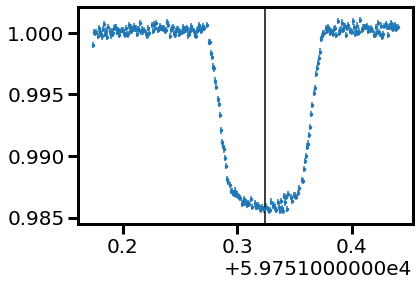

In [247]:
plt.errorbar(data_dictionary['white-light-order1']['times'], 
             data_dictionary['white-light-order1']['flux'],
             yerr=data_dictionary['white-light-order1']['error'],
             marker='.', linestyle='')
plt.axvline(hyperps[1][0], color='k')

In [248]:
results = fit_lightcurves(data_dictionary,  priors_dictionary, sampler='dynesty')

Detected dynesty sampler output files --- extracting from white-light-order1/_dynesty_NS_posteriors.pkl


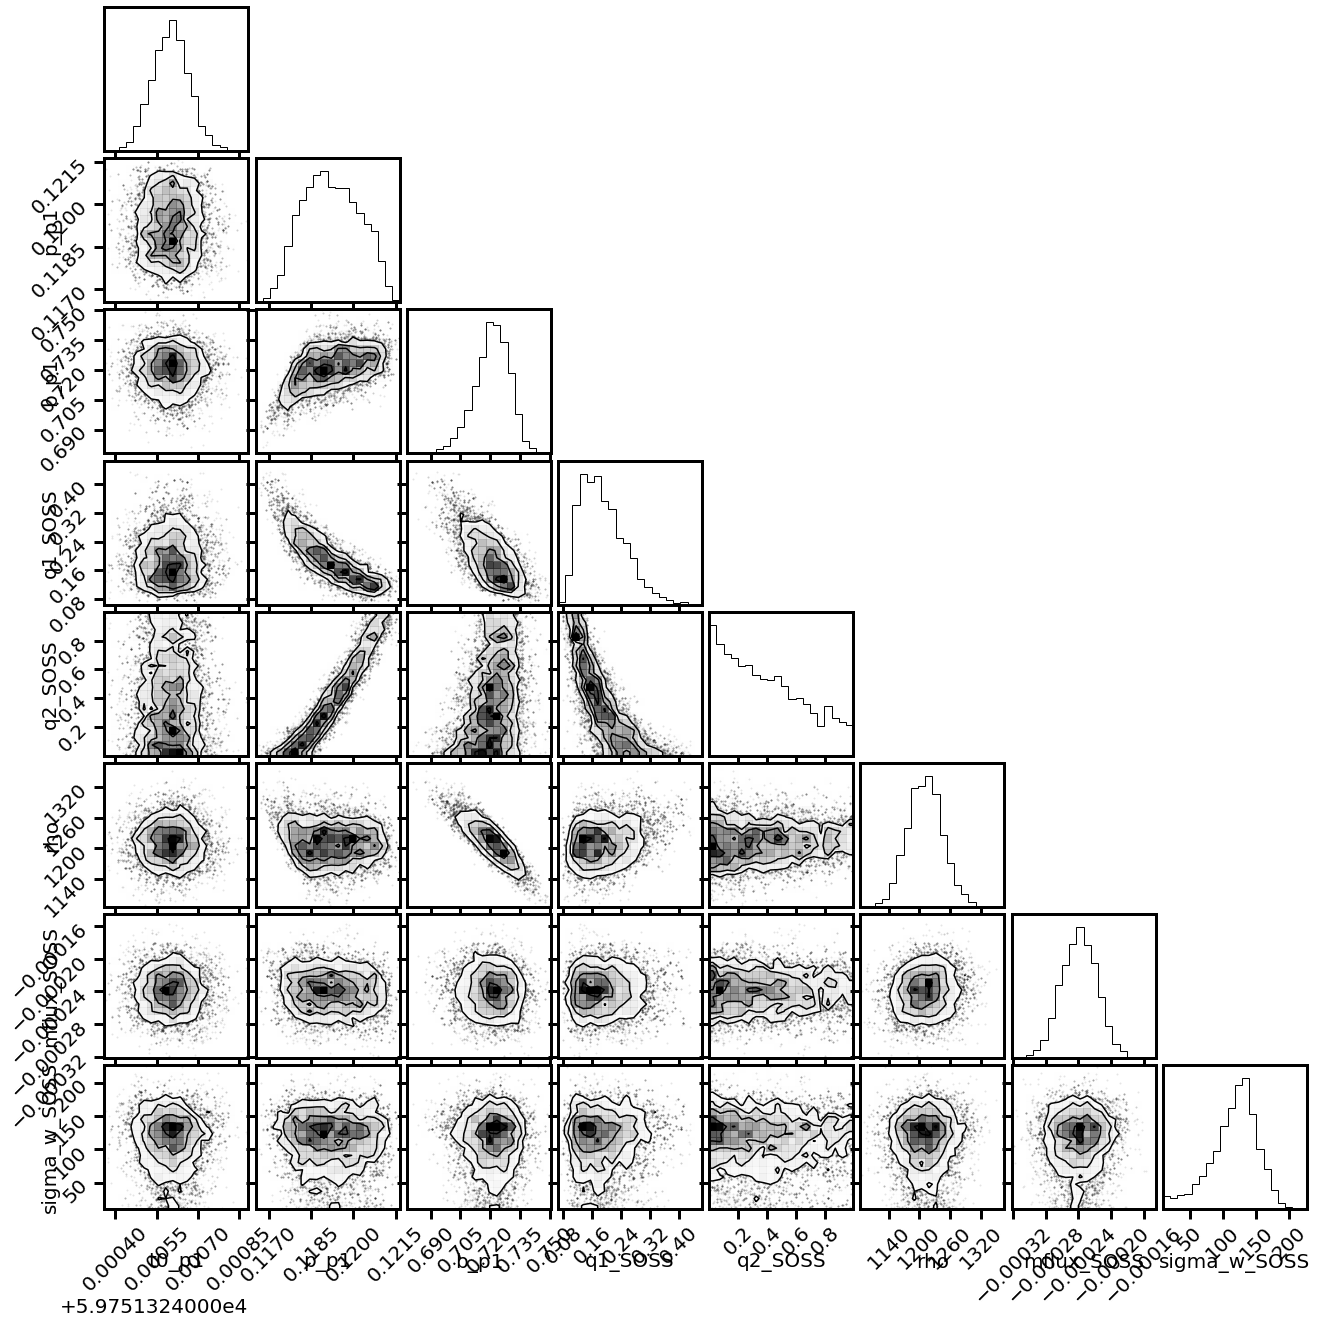

In [249]:
figure = corner_plot(results, 'white-light-order1')

# Step 2: Fitting Spectroscopic Light Curves

In [263]:
centers = np.zeros(len(priors1))
for i in range(len(priors1)):
    k = list(priors1.keys())[i].split('_')[-1]
    centers[i] = float(k)
centers = np.logspace(np.log10(centers[0]), np.log10(centers[-1]), 100)
binsize = np.append(0.01,np.diff(centers)/3)

In [266]:
params = ['P_p1',
          't0_p1',
          'p_p1',
          'a_p1',
          'b_p1', 'q1_SOSS',
          'q2_SOSS',
          'ecc_p1',
          'omega_p1',
          'rho', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed',
         'fixed',
         'uniform',
         'fixed',
         'fixed', 
         'truncatednormal',
         'truncatednormal',
         'fixed','fixed',
         'fixed', 
         'fixed', 'normal', 'loguniform'] 

q1 = np.nanmedian(results['white-light-order1'].posteriors['posterior_samples']['q1_SOSS'])
q2 = np.nanmedian(results['white-light-order1'].posteriors['posterior_samples']['q2_SOSS'])

# Hyperparameters
hyperps = [3.4252602, 
           np.nanmedian(results['white-light-order1'].posteriors['posterior_samples']['t0_p1']),
           [0.,0.2],
           8.84,
           np.nanmedian(results['white-light-order1'].posteriors['posterior_samples']['b_p1']), 
           [q1, 0.1, 0.0, 1.0], 
           [q2, 0.1, 0.0, 1.0], 
           0.0, 90.,
           np.nanmedian(results['white-light-order1'].posteriors['posterior_samples']['rho']), 
           1.0, 
           [0.0,0.1], 
           [10.0, 1000.]]

In [269]:
data_dictionary = create_data_dictionary(centers, wavelength1, flux1, var1, times, 
                                         binsize)
priors_dictionary = create_priors_dictionary(keys=list(data_dictionary.keys()),
                                             params=params,
                                             dists=dists,
                                             hyperps=hyperps)

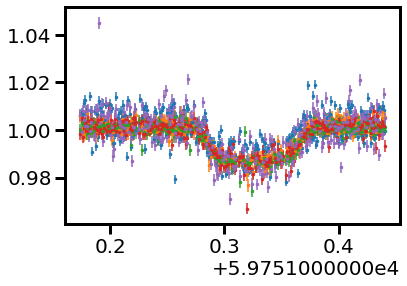

In [270]:
for i in np.linspace(0, len(centers)-1, 5, dtype=int):
    plt.errorbar(data_dictionary['wave_{}'.format(np.round(centers[i],5))]['times'], 
                 data_dictionary['wave_{}'.format(np.round(centers[i],5))]['flux'],
                 yerr=data_dictionary['wave_{}'.format(np.round(centers[i],5))]['error'],
                 marker='.', linestyle='')

In [271]:
spec_results = fit_lightcurves(data_dictionary,  priors_dictionary, sampler='dynesty')

9867it [01:02, 157.66it/s, +500 | bound: 108 | nc: 1 | ncall: 220126 | eff(%):  4.720 | loglstar:   -inf < 368.775 <    inf | logz: 349.686 +/-  0.193 | dlogz:  0.001 >  0.509] 
6046it [00:36, 167.21it/s, +500 | bound: 57 | nc: 1 | ncall: 124585 | eff(%):  5.275 | loglstar:   -inf < 1202.793 <    inf | logz: 1191.402 +/-  0.150 | dlogz:  0.001 >  0.509]
5714it [00:33, 170.05it/s, +500 | bound: 52 | nc: 1 | ncall: 115756 | eff(%):  5.391 | loglstar:   -inf < 1213.528 <    inf | logz: 1202.882 +/-  0.141 | dlogz:  0.001 >  0.509]
5745it [00:43, 132.09it/s, +500 | bound: 53 | nc: 1 | ncall: 116704 | eff(%):  5.374 | loglstar:   -inf < 1228.109 <    inf | logz: 1217.406 +/-  0.141 | dlogz:  0.001 >  0.509]
5693it [00:33, 169.94it/s, +500 | bound: 53 | nc: 1 | ncall: 116654 | eff(%):  5.332 | loglstar:   -inf < 1209.006 <    inf | logz: 1198.407 +/-  0.140 | dlogz:  0.001 >  0.509]
5503it [00:31, 172.11it/s, +500 | bound: 51 | nc: 1 | ncall: 111804 | eff(%):  5.393 | loglstar:   -inf < 1162

8203it [00:56, 144.02it/s, +500 | bound: 85 | nc: 1 | ncall: 177839 | eff(%):  4.908 | loglstar:   -inf < 1115.796 <    inf | logz: 1100.084 +/-  0.177 | dlogz:  0.001 >  0.509]
8192it [00:57, 143.13it/s, +500 | bound: 87 | nc: 1 | ncall: 179453 | eff(%):  4.857 | loglstar:   -inf < 1106.897 <    inf | logz: 1091.192 +/-  0.177 | dlogz:  0.001 >  0.509]
8404it [00:58, 143.52it/s, +500 | bound: 89 | nc: 1 | ncall: 182936 | eff(%):  4.881 | loglstar:   -inf < 1111.240 <    inf | logz: 1095.094 +/-  0.180 | dlogz:  0.001 >  0.509]
8072it [00:56, 142.55it/s, +500 | bound: 85 | nc: 1 | ncall: 176796 | eff(%):  4.862 | loglstar:   -inf < 1108.310 <    inf | logz: 1092.847 +/-  0.176 | dlogz:  0.001 >  0.509]
9154it [01:04, 142.57it/s, +500 | bound: 99 | nc: 1 | ncall: 202940 | eff(%):  4.769 | loglstar:   -inf < 1076.846 <    inf | logz: 1059.193 +/-  0.192 | dlogz:  0.001 >  0.509]
8599it [01:00, 142.78it/s, +500 | bound: 90 | nc: 1 | ncall: 186829 | eff(%):  4.883 | loglstar:   -inf < 994.

# Step 3 -- Repeat Steps 1 & 2 with the 2nd Order

In [191]:
params = ['P_p1','t0_p1','p_p1',
          'a_p1',
          'b_p1', 'q1_SOSS',
          'q2_SOSS','ecc_p1',
          'omega_p1',
          'rho', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed',
         'normal',
         'uniform',
         'fixed',
         'normal', 
         'uniform',
         'uniform',
         'fixed','fixed',
         'uniform', 
         'fixed', 'normal', 'loguniform'] 

# Hyperparameters
hyperps = [3.4252602, 
           [2459751.824667617-2400000.5,0.001], 
           [0.,0.2],
           8.84,
           [0.4,0.2], 
           [0., 1.0],#[0.4, 0.1, 0.0, 1.0], 
           [0., 1.0],#[0.4, 0.1, 0.0, 1.0], 
           0.0, 90.,
           [100., 10000.], 
           1.0, 
           [0.0,0.1], 
           [10.0, 1000.]]

In [192]:
centers = np.array([np.nanmedian(wavelength2)])
binsize = np.array([(wavelength2[0]-wavelength2[-1])/2])
data_dictionary = create_data_dictionary(centers, wavelength2, flux2, var2, times, 
                                         binsize, key='white-light-order2')
priors_dictionary = create_priors_dictionary(keys=list(data_dictionary.keys()),
                                             params=params,
                                             dists=dists,
                                             hyperps=hyperps)

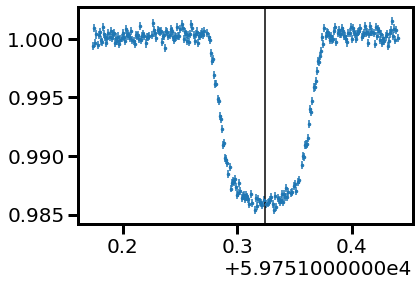

In [193]:
plt.errorbar(data_dictionary['white-light-order2']['times'], 
             data_dictionary['white-light-order2']['flux'],
             yerr=data_dictionary['white-light-order2']['error'],
             marker='.', linestyle='')
plt.axvline(hyperps[1][0], color='k')

In [194]:
results2 = fit_lightcurves(data_dictionary,  priors_dictionary, sampler='dynesty')

16399it [01:55, 141.54it/s, +500 | bound: 196 | nc: 1 | ncall: 425918 | eff(%):  3.972 | loglstar:   -inf < 1696.928 <    inf | logz: 1664.730 +/-  0.252 | dlogz:  0.001 >  0.509]


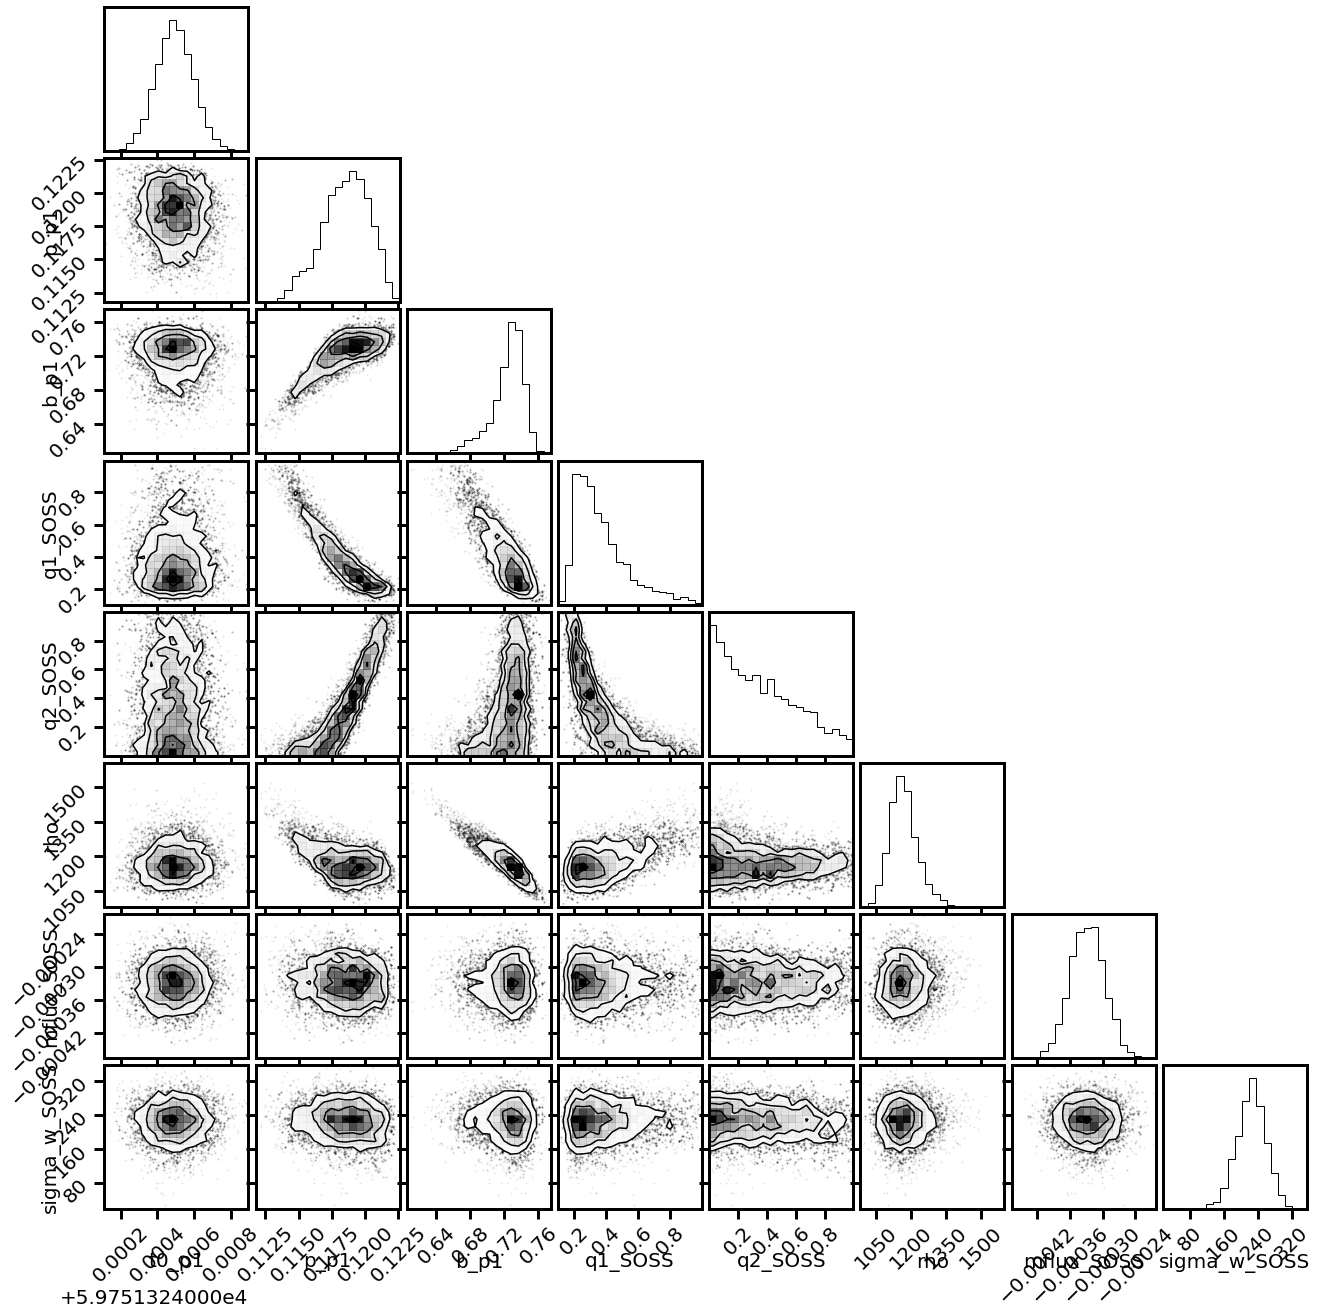

In [196]:
figure = corner_plot(results2, 'white-light-order2')

## Step 2 for Order 2

In [273]:
mask = (wavelength2 > 0) & (flux2[0] > 0)
centers = np.logspace(np.log10(0.58), np.log10(1.01), 30)
binsize = np.append(0.005,np.diff(centers)/3)

In [277]:
params = ['P_p1',
          't0_p1',
          'p_p1',
          'a_p1',
          'b_p1', 'q1_SOSS',
          'q2_SOSS',
          'ecc_p1',
          'omega_p1',
          'rho', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS']

# Distributions:
dists = ['fixed',
         'fixed',
         'uniform',
         'fixed',
         'fixed', 
         'truncatednormal',
         'truncatednormal',
         'fixed','fixed',
         'fixed', 
         'fixed', 'normal', 'loguniform'] 

q1 = np.nanmedian(results2['white-light-order2'].posteriors['posterior_samples']['q1_SOSS'])
q2 = np.nanmedian(results2['white-light-order2'].posteriors['posterior_samples']['q2_SOSS'])

# Hyperparameters
hyperps = [3.4252602, 
           np.nanmedian(results2['white-light-order2'].posteriors['posterior_samples']['t0_p1']),
           [0.,0.2],
           8.84,
           np.nanmedian(results2['white-light-order2'].posteriors['posterior_samples']['b_p1']), 
           [q1, 0.1, 0.0, 1.0], 
           [q2, 0.1, 0.0, 1.0], 
           0.0, 90.,
           np.nanmedian(results2['white-light-order2'].posteriors['posterior_samples']['rho']), 
           1.0, 
           [0.0,0.1], 
           [10.0, 1000.]]

In [278]:
data_dictionary = create_data_dictionary(centers, 
                                         wavelength2[mask], 
                                         flux2[:,mask], 
                                         var2[:,mask], 
                                         times, 
                                         binsize)
priors_dictionary = create_priors_dictionary(keys=list(data_dictionary.keys()),
                                             params=params,
                                             dists=dists,
                                             hyperps=hyperps)

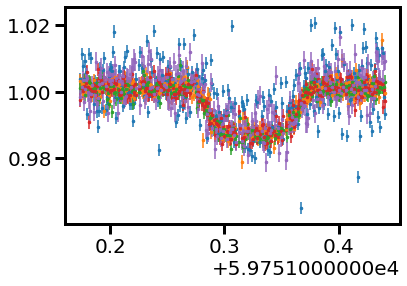

In [279]:
for i in np.linspace(0, len(centers)-1, 5, dtype=int):
    plt.errorbar(data_dictionary['wave_{}'.format(np.round(centers[i],5))]['times'], 
                 data_dictionary['wave_{}'.format(np.round(centers[i],5))]['flux'],
                 yerr=data_dictionary['wave_{}'.format(np.round(centers[i],5))]['error'],
                 marker='.', linestyle='')

In [280]:
spec_results2 = fit_lightcurves(data_dictionary,  priors_dictionary, 
                                sampler='dynesty')

12721it [01:31, 139.61it/s, +500 | bound: 147 | nc: 1 | ncall: 292149 | eff(%):  4.533 | loglstar:   -inf < -463.923 <    inf | logz: -488.853 +/-  0.219 | dlogz:  0.001 >  0.509]
8931it [01:01, 144.94it/s, +500 | bound: 97 | nc: 1 | ncall: 197920 | eff(%):  4.777 | loglstar:   -inf < 771.644 <    inf | logz: 754.491 +/-  0.184 | dlogz:  0.001 >  0.509] 
7420it [00:49, 148.64it/s, +500 | bound: 77 | nc: 1 | ncall: 160374 | eff(%):  4.954 | loglstar:   -inf < 1174.626 <    inf | logz: 1160.470 +/-  0.168 | dlogz:  0.001 >  0.509]
7792it [00:53, 146.57it/s, +500 | bound: 82 | nc: 1 | ncall: 169656 | eff(%):  4.902 | loglstar:   -inf < 1179.511 <    inf | logz: 1164.603 +/-  0.173 | dlogz:  0.001 >  0.509]
8657it [00:58, 147.48it/s, +500 | bound: 90 | nc: 1 | ncall: 188246 | eff(%):  4.877 | loglstar:   -inf < 1131.381 <    inf | logz: 1114.729 +/-  0.183 | dlogz:  0.001 >  0.509]
5898it [00:37, 156.36it/s, +500 | bound: 56 | nc: 1 | ncall: 122039 | eff(%):  5.264 | loglstar:   -inf < 124